In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join, basename,exists
from glob import glob
from tqdm import tqdm

from infrasound import prep, mseed2arr, prep_wx, daily_power, daily_hour_power, slice_power, get_day, strf_date, dB_convert

from obspy import read
from scipy.signal import correlate, correlation_lags, butter, filtfilt, spectrogram
from scipy.stats import pearsonr
from numpy.fft import fft, fftfreq, ifft, fftshift
import statsmodels.api as sm


In [3]:
in_dir = '/home/zacharykeskinen/data/infrasound/infrasound/processed'
in_dir = '../../data/banner/infrasound/processed'
csv_dir = '../../data/csvs/powers/'

days, stats = prep(in_dir)
wx = prep_wx()

ac_calib = 8.2928e-05
name_dic = {'be4':'lower','a3m':'upper','ad8':'failed array'}
height_dic = {'lower-p0':0.33,'lower-p1':0.66,'lower-p2':1,'upper-p0':1.33,'upper-p1':np.nan,'upper-p2':2}

in_dir = '/home/zacharykeskinen/data/infrasound/infrasound/processed' #infrasound/banner/infrasound/processed/'
in_dir = '../../data/banner/infrasound/processed'
exists(in_dir)


# l = os.listdir(in_dir)
l = glob(os.path.join(in_dir, 'c0be4*'))
r = []
for i in l:
    i = os.path.basename(i)
    j = i[5:11]
    if j not in r:
        r.append(j)
r.sort()

def get_hour(arr, hour, sps = 200,):
    n = 60*sps*60
    return arr[hour*n:(hour+1)*n]

<AxesSubplot:xlabel='Date_Time'>

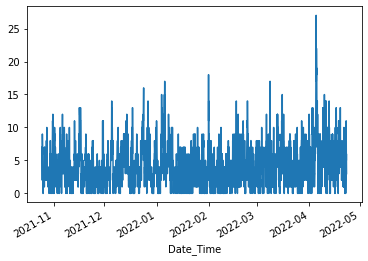

In [4]:
wind_wx = pd.read_csv('/home/zacharykeskinen/Documents/infrasound/data/bearskin_creek/BCFI1.csv', skiprows = 6)
wind_wx = wind_wx[1:]
wind_wx.Date_Time = pd.to_datetime(wind_wx.Date_Time)
wind_wx = wind_wx.set_index('Date_Time')
wind_wx = wind_wx.drop(['Station_ID'], axis = 1)
for col in wind_wx.columns:
    wind_wx.loc[:,col] = wind_wx[col].astype(float)
daily = wind_wx.resample('1D').mean()
upper_speed_hours = wind_wx.loc[wind_wx.wind_speed_set_1>2, 'wind_speed_set_1']
wind_wx.wind_speed_set_1.plot()

In [20]:
df = pd.DataFrame()
j = 0
for hour, wind in tqdm(upper_speed_hours.iteritems(), total = len(upper_speed_hours)):
    for day in r:
        if strf_date(day).day == hour.day:
            data = get_day(r, day, in_dir = in_dir, name_dic=name_dic, height_dic = height_dic)
            if data[0.33].size == 17280000:
                for height, arr in data.items():
                    hour_arr = get_hour(arr, hour.hour)
                    power = arr**2
                    power = 1/len(power) * np.cumsum(power)[-1]
                    df = df.append({'wind':wind, 'power': power, 'height': height}, ignore_index = True)
    j += 1
    if j%50 == 0:
        df.to_csv(join(csv_dir, f'wind_hourly_power.csv'))

100%|██████████| 2883/2883 [6:30:16<00:00,  8.12s/it]  


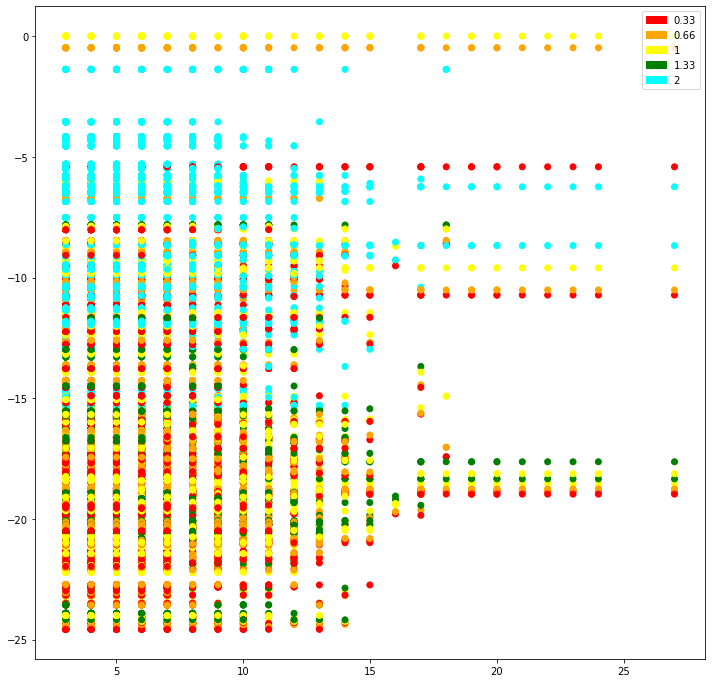

In [21]:
import matplotlib.patches as mpatches

plt.figure(figsize = (12,12))
color_dic = {0.33:'red',0.66:'orange',1:'yellow',1.33:'green',2:'aqua'}
plt.scatter(x = df.wind, y = dB_convert(df.power), c = [color_dic[i] for i in df.height])

fake_handles = [mpatches.Patch(color=item) for item in color_dic.values()]
label = color_dic.keys()
plt.legend(fake_handles, label, loc='upper right', prop={'size': 10})

In [6]:
day

'220204'

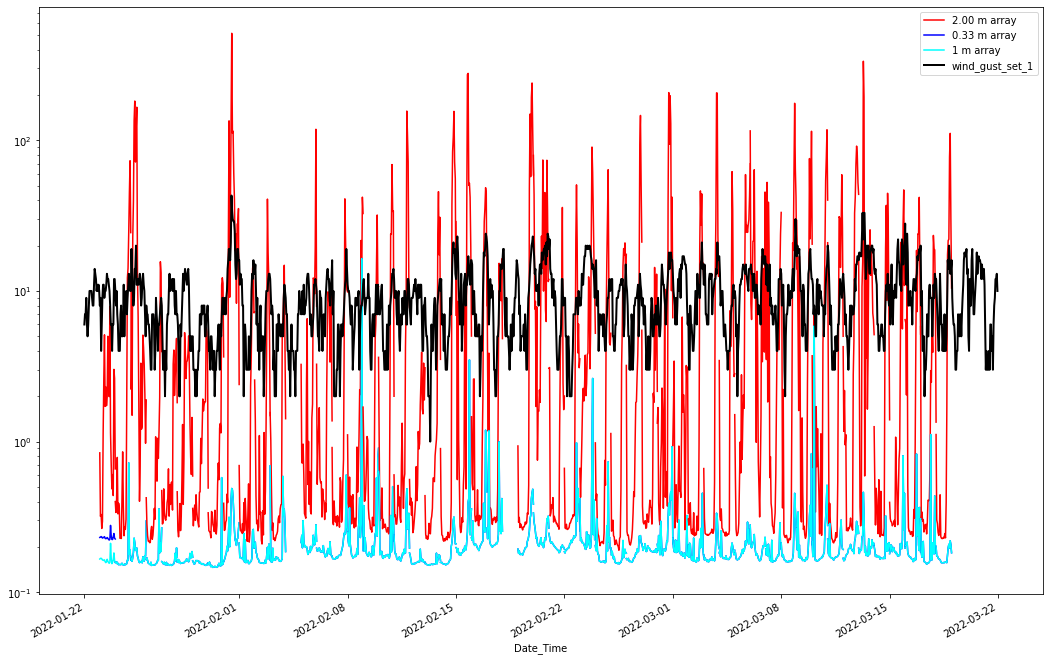

In [13]:
plt.figure(figsize=(18,12))
t1 = '2022-01-22'
t2 = '2022-03-22'
wind_sub = wind_wx.loc[(wind_wx.index > pd.to_datetime(t1, utc = True))&(wind_wx.index < pd.to_datetime(t2, utc = True))]
j = 0
for day in r:
    if strf_date(day) > pd.to_datetime(t1) and strf_date(day) < pd.to_datetime(t2):
        data = get_day(r, eq_day = day, in_dir= in_dir, name_dic=name_dic, height_dic=height_dic)
        if data[0.33].size == 24*60*60*200:
                powers_high = daily_hour_power(data[2], f_low=2, f_high=30)
                powers_low = daily_hour_power(data[0.33], f_low=2, f_high=30)
                powers_mid = daily_hour_power(data[1], f_low=2, f_high=30)
        #         t = np.linspace(strf_date(day), strf_date(day) + pd.Timedelta('1 day'))
                t = pd.date_range(strf_date(day), strf_date(day) + pd.Timedelta('1 day'), 24)
                if j == 0:
                        plt.plot(t, powers_high, label = '2.00 m array', color = 'red')
                        plt.plot(t, powers_low, label = '0.33 m array', color = 'blue')
                        plt.plot(t, powers_mid, label = '1 m array', color = 'aqua')
                        j = 1
                else:
                        plt.plot(t, powers_high, color = 'red')
                        plt.plot(t, powers_mid, color = 'blue') 
                        plt.plot(t, powers_mid, color = 'aqua')
wind_sub.wind_gust_set_1.plot(color = 'black', linewidth = 2)
plt.legend()
plt.yscale('log')

In [16]:
a = np.array([0,1,2])
b = np.array([0,1,3])
c = np.append(a,b)
c

array([0, 1, 2, 0, 1, 3])

Text(2022-01-23 00:00:00, 170, 'high-wind r2: 0.0867448548702737')

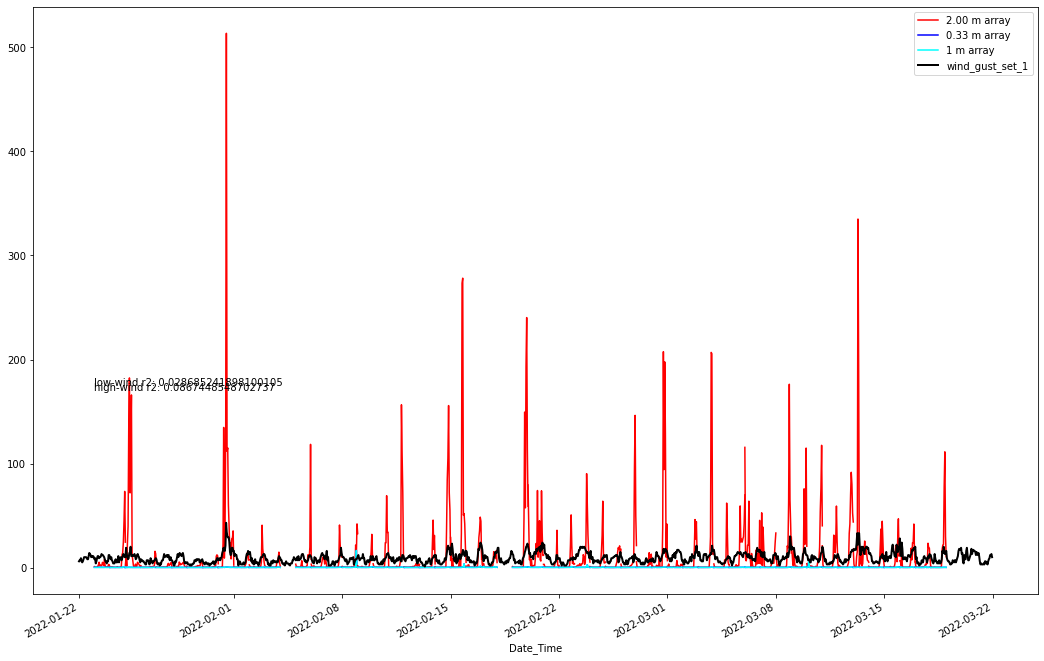

In [27]:
low = np.array([])
high = np.array([])
plt.figure(figsize=(18,12))
t1 = '2022-01-22'
t2 = '2022-03-22'
wind_sub = wind_wx.loc[(wind_wx.index > pd.to_datetime(t1, utc = True))&(wind_wx.index < pd.to_datetime(t2, utc = True))]
wind_arr = wind_sub.wind_gust_set_1.values
j = 0
for day in r:
    if strf_date(day) > pd.to_datetime(t1) and strf_date(day) < pd.to_datetime(t2):
        data = get_day(r, eq_day = day, in_dir= in_dir, name_dic=name_dic, height_dic=height_dic)
        if data[0.33].size == 24*60*60*200:
                powers_high = daily_hour_power(data[2], f_low=2, f_high=30)
                powers_low = daily_hour_power(data[0.33], f_low=2, f_high=30)
                powers_mid = daily_hour_power(data[1], f_low=2, f_high=30)
        #         t = np.linspace(strf_date(day), strf_date(day) + pd.Timedelta('1 day'))
                t = pd.date_range(strf_date(day), strf_date(day) + pd.Timedelta('1 day'), 24)
                if j == 0:
                        plt.plot(t, powers_high, label = '2.00 m array', color = 'red')
                        plt.plot(t, powers_low, label = '0.33 m array', color = 'blue')
                        plt.plot(t, powers_mid, label = '1 m array', color = 'aqua')
                        low = np.append(low, powers_low)
                        high = np.append(high, powers_high)
                        j = 1
                else:
                        plt.plot(t, powers_high, color = 'red')
                        plt.plot(t, powers_mid, color = 'blue') 
                        plt.plot(t, powers_mid, color = 'aqua')
                        low = np.append(low, powers_low)
                        high = np.append(high, powers_high)
wind_sub.wind_gust_set_1.plot(color = 'black', linewidth = 2)
plt.legend()
r_low = pearsonr(low, wind_arr[:low.size])[0]
r_high = pearsonr(high, wind_arr[:high.size])[0]
plt.text(pd.to_datetime('2022-01-23'), 175, f'low-wind r2: {r_low}')
plt.text(pd.to_datetime('2022-01-23'), 170, f'high-wind r2: {r_high}')

# plt.yscale('log')